In [13]:
"""
    Potential hostless candidates detection usibng sigma clipping
"""

from typing import List

from astropy.stats import sigma_clip
from astropy.visualization import simple_norm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams.update({'font.size': 8})

In [14]:
# parameters
EXTRAGALACTIC_FILE = "/media3/CRP7/hosts/data/EXTRAGALACTIC/extragal_nocathost.pkl"
SIGMA_CLIP_KWARGS = {
    "sigma": 3,
    "maxiters": 10
}
MIN_NUMBER_OF_SCIENCE_PIXELS_CLIPPED = 5
MIN_NUMBER_OF_TEMPLATE_PIXELS_CLIPPED = 0

In [15]:
def load_pickle_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Loads pickle file to pandas data frame

    Parameters
    ----------
    file_path
       input file path 
    """
    return pd.read_pickle(file_path)


def extract_center_patch(input_image: np.ndarray, patch_scale_center: float = 0.1) -> np.ndarray:
    """
    Extracts rectangular patch around image center with a given patch scale

    Parameters
    ----------
    input_image
       input image
    patch_scale_center
        patch scale value between [0, 1]
    """
    image_shape = input_image.shape[0:2]
    center_coords = [image_shape[0] / 2, image_shape[1] / 2]
    smaller_side = np.min(input_image.shape[0:2])
    patch_size = int(patch_scale_center * smaller_side)
    center_patch_x = int(center_coords[0] - patch_size / 2.)
    center_patch_y = int(center_coords[1] - patch_size / 2.)
    return input_image[center_patch_x:center_patch_x + patch_size,
                center_patch_y:center_patch_y + patch_size]


def get_hostless_candidates_with_sigma_clipping(input_data: pd.DataFrame) -> List:
    """
    Detects potential hostless candidates. Sigmal clipping is applied to science and template
    images by cropping an image patch from the center of the image. 
    If pixels are rejected in scientific image but not in corresponding template image, such
    candidates are flagged as potential hostless

    Parameters
    ----------
    input_data
       input extragalactic dataframe
    """
    potential_hostless_ids = []
    for index, each_row in input_data.iterrows():
        cutoutScience_stampData_last = each_row["b:cutoutScience_stampData_last"].astype(float)
        cutoutTemplate_stampData_last = each_row["b:cutoutTemplate_stampData_last"].astype(float)
        cutoutScience_stampData_last[np.isnan(cutoutScience_stampData_last)] = 0
        cutoutTemplate_stampData_last[np.isnan(cutoutTemplate_stampData_last)] = 0

        science_patch_center = extract_center_patch(cutoutScience_stampData_last)
        template_patch_center = extract_center_patch(cutoutTemplate_stampData_last)

        science_cropped_clipped = sigma_clip(science_patch_center, **SIGMA_CLIP_KWARGS)
        template_cropped_clipped = sigma_clip(template_patch_center, **SIGMA_CLIP_KWARGS)

        num_science_pixels_masked = np.ma.count_masked(science_cropped_clipped)
        num_template_pixels_masked = np.ma.count_masked(template_cropped_clipped)

        if (num_science_pixels_masked > MIN_NUMBER_OF_SCIENCE_PIXELS_CLIPPED and
            num_template_pixels_masked == MIN_NUMBER_OF_TEMPLATE_PIXELS_CLIPPED):
            potential_hostless_ids.append([index, each_row["i:objectId"]])

    print("Number of potential hostless candidates {}".format(len(potential_hostless_ids)))
    return potential_hostless_ids


def plot_hostless_ids(input_data: pd.DataFrame, hostless_ids: List):
    """
    Plots stamp images of hostless candidates

    Parameters
    ----------
    input_data
       input extragalactic dataframe
    hostless_ids
        list of potential hostless candidates
    """

    plots_title = ["cutoutScience_stampData_last", "cutoutTemplate_stampData_last",
                "cutoutDifference_stampData_last"]
    for index, each_object_id in hostless_ids: 
        potential_sample = input_data.iloc[index]
        cutoutScience_stampData_last = potential_sample["b:cutoutScience_stampData_last"].astype(float)
        cutoutTemplate_stampData_last = potential_sample["b:cutoutTemplate_stampData_last"].astype(float)
        cutoutDifference_stampData_last = potential_sample["b:cutoutDifference_stampData_last"].astype(float)

        cutoutScience_stampData_last[np.isnan(cutoutScience_stampData_last)] = 0
        cutoutTemplate_stampData_last[np.isnan(cutoutTemplate_stampData_last)] = 0
        images_to_plot = [cutoutScience_stampData_last, cutoutTemplate_stampData_last,
                        cutoutDifference_stampData_last]
        fig, axes = plt.subplots(1,3, figsize=(9,3))
        fig.suptitle(each_object_id)
        for i, ax in enumerate(axes.flat):
            ax.set_title(plots_title[i])
            norm = simple_norm(images_to_plot[i], 'log', percent=99.)
            ax.imshow(images_to_plot[i], norm=norm, origin='lower', interpolation='nearest')
            ax.axhline(30, color='r', alpha=0.3)
            ax.axvline(30, color='r', alpha=0.3)

Number of potential hostless candidates 12


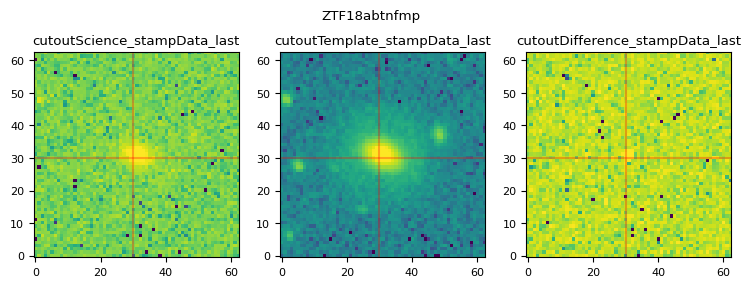

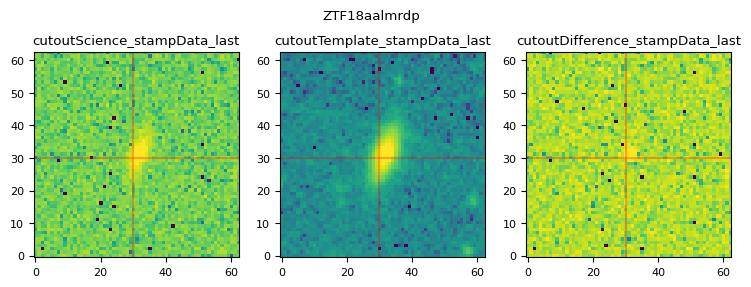

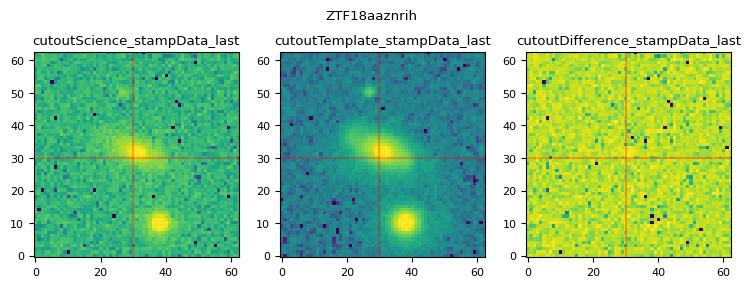

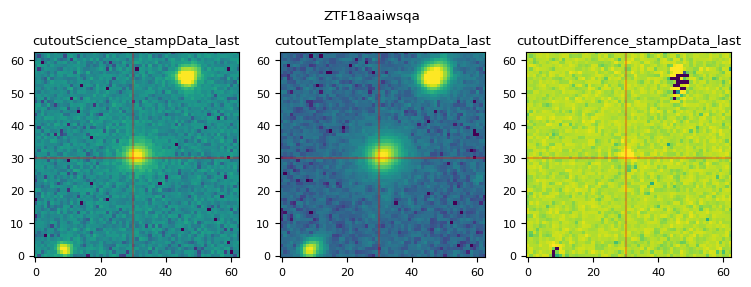

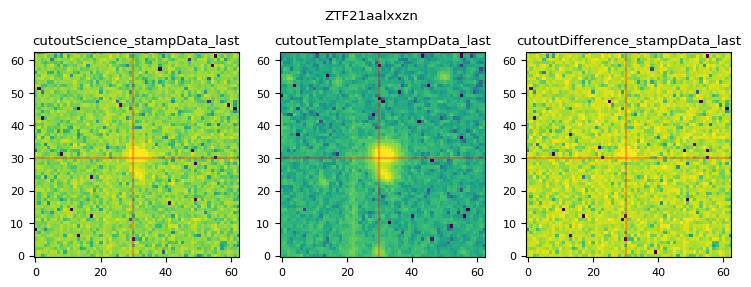

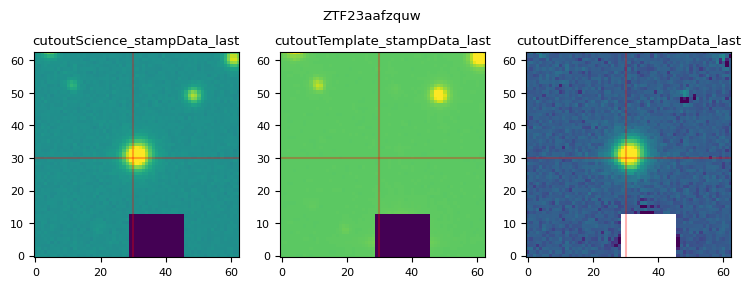

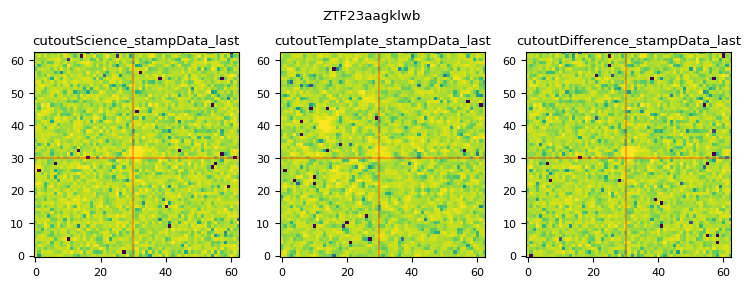

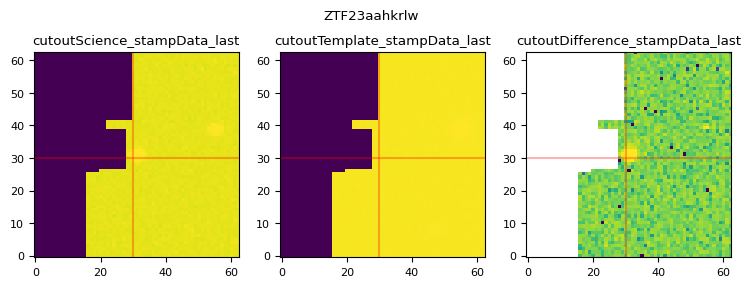

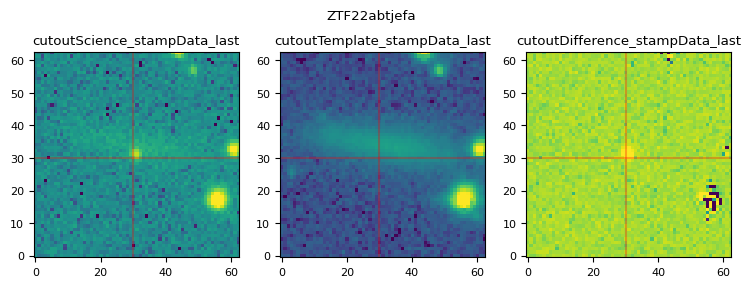

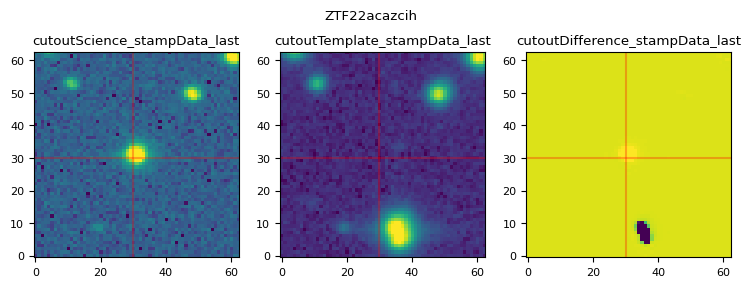

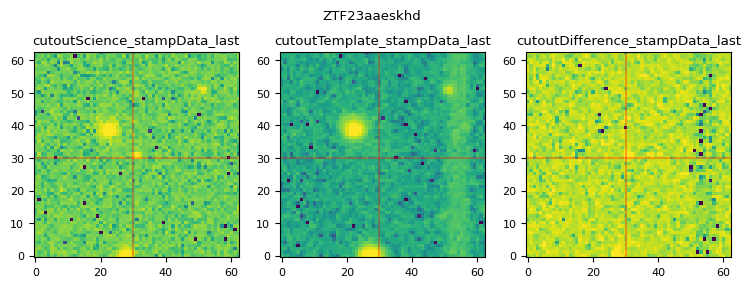

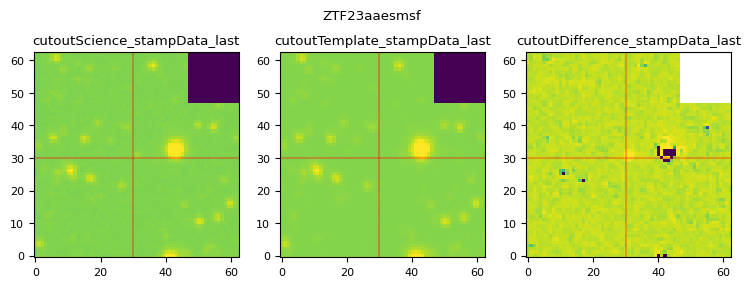

In [16]:
extragalactic_data = load_pickle_to_dataframe(EXTRAGALACTIC_FILE)
hostless_candidates = get_hostless_candidates_with_sigma_clipping(extragalactic_data)
plot_hostless_ids(extragalactic_data, hostless_candidates)
